<a href="https://colab.research.google.com/github/YUseiDoi/funk-svd_als/blob/main/funk_svd_als.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 行列分解のアルゴリズムである Funk-SVD, ALS の実装

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [3]:
user_num = 100
item_num = 20
ratings = np.zeros([user_num, item_num])  # 100 x 1000の評価値行列を作成
ratings[:,:] = np.nan

# 擬似的に評価値（nan, 1～5）行列を作成
for i in range(user_num):
  for j in range(item_num):
    if random.random() > 0.5:
      ratings[i, j] = int(random.random() * 5) + 1

ratings

array([[ 3.,  3.,  2., ...,  1.,  5.,  2.],
       [ 2.,  4., nan, ...,  2.,  3., nan],
       [nan, nan, nan, ...,  3.,  2., nan],
       ...,
       [nan,  1.,  4., ..., nan, nan,  1.],
       [nan,  4.,  4., ..., nan,  5.,  1.],
       [nan,  1., nan, ...,  3.,  2., nan]])

In [7]:
# 評価関数
def calc_mse(P, Q, R):
  mse = []
  for (u, i), r_ui in np.ndenumerate(R):
    if not np.isnan(r_ui):
      mse.append((r_ui - np.dot(P[:, u], Q[:, i])) ** 2)
  return np.mean(mse)

In [8]:
# 損失関数
def calc_loss(P, Q, R):
  loss = 0
  for (u, i), r_ui in np.ndenumerate(R):
    if not np.isnan(r_ui):
      loss += (r_ui - np.dot(P[:, u], Q[:, i])) ** 2 + l_reg * (np.linalg.norm(P[:, u]) + np.linalg.norm(Q[:, i]))
  return loss

# Funk-SVD

In [57]:
# Funk-SVD

f = 10          # 潜在因子数
alpha = 0.01    # 学習率
l_reg = 0.1     # 正則化項の係数
n = 1000        # ループ数
mse_svd = []    # 学習中の評価関数
loss_svd = []   # 学習中の損失関数

# ユーザ因子行列（P），アイテム因子行列（Q）の初期化
P = np.zeros([f, user_num])
Q = np.zeros([f, item_num])

for i in range(f):
  for j in range(user_num):
    P[i, j] = random.uniform(0, 1 / np.sqrt(f))

for i in range(f):
  for j in range(item_num):
    Q[i, j] = random.uniform(0, 1 / np.sqrt(f))

# 行列要素の更新
for step in range(n):
  for (u, i), r_ui in np.ndenumerate(ratings):
    if not np.isnan(r_ui):
      err_ui = r_ui - np.dot(P[:, u], Q[:, i])
      for k in range(f):
        P[k, u] += alpha * (Q[k, i] * err_ui - l_reg * P[k, u])
        Q[k, i] += alpha * (P[k, u] * err_ui - l_reg * Q[k, i])

  # 評価関数・損失関数
  current_mse = calc_mse(P, Q, ratings)
  mse_svd.append(current_mse)
  current_loss = calc_loss(P, Q, ratings)
  loss_svd.append(current_loss)
  if step % 100 == 0 or step == n - 1: print(f'step: {step}, loss: {current_loss}, mse: {current_mse}')

step: 0, loss: 6318.237474637844, mse: 6.011895308816092
step: 100, loss: 750.0159835071125, mse: 0.2728349979252713
step: 200, loss: 683.6692317389321, mse: 0.19978811419251502
step: 300, loss: 669.7128270532962, mse: 0.18475950652841813
step: 400, loss: 663.6453796456799, mse: 0.1783778644258293
step: 500, loss: 659.9796328229471, mse: 0.17449496898454048
step: 600, loss: 657.5288408742446, mse: 0.17185973854348358
step: 700, loss: 655.8981354821467, mse: 0.1700935880829074
step: 800, loss: 654.808499469039, mse: 0.16891411569093717
step: 900, loss: 654.0618623613655, mse: 0.16810888861557485
step: 999, loss: 653.5431745937686, mse: 0.167551502303853


In [58]:
np.dot(P[:, 0], Q[:, 0])

2.4246502656446167

In [59]:
np.dot(P[:, 0], Q[:, 1])

2.456634478959396

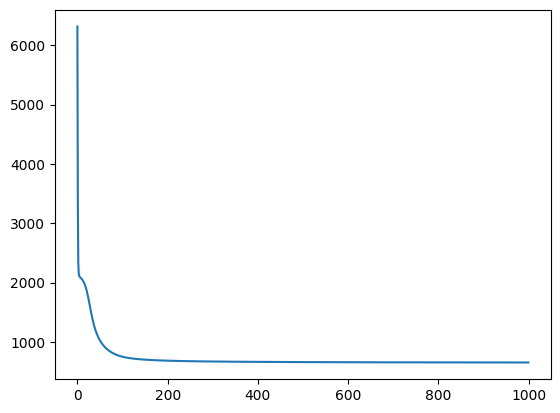

In [60]:
plt.plot(loss_svd)

# ALS

In [68]:
# ALS

f = 10          # 潜在因子数
l_reg = 0.01    # 正則化項の係数
n = 1000        # ループ数
mse_als = []    # 学習中の評価関数
loss_als = []   # 学習中の損失関数

# ユーザ因子行列（P），アイテム因子行列（Q）の初期化
P = np.zeros([f, user_num])
Q = np.zeros([f, item_num])


for i in range(f):
  for j in range(user_num):
    P[i, j] = random.uniform(0, 1 / np.sqrt(f))

for i in range(f):
  for j in range(item_num):
    Q[i, j] = random.uniform(0, 1 / np.sqrt(f))

for step in range(n):
    for u in range(ratings.shape[0]):
      user_ratings_vector = np.zeros(f)
      user_covariance_matrix = np.zeros([f, f])
      for i in range(ratings.shape[1]):
        if not np.isnan(ratings[u, i]):
          user_ratings_vector += ratings[u, i] * Q[:, i]
          user_covariance_matrix += np.outer(Q[:, i], Q[:, i])
      user_covariance_matrix += np.eye(f) * l_reg
      P[:, u] = np.dot(np.linalg.inv(user_covariance_matrix), user_ratings_vector.reshape(-1))

    for i in range(ratings.shape[1]):
      user_ratings_vector = np.zeros(f)
      user_covariance_matrix = np.zeros([f, f])
      for u in range(ratings.shape[0]):
        if not np.isnan(ratings[u, i]):
            user_ratings_vector += ratings[u, i] * P[:, u]
            user_covariance_matrix += np.outer(P[:, u], P[:, u])
      user_covariance_matrix += np.eye(f) * l_reg
      Q[:, i] = np.dot(np.linalg.inv(user_covariance_matrix), user_ratings_vector.reshape(-1))

    # 評価関数・損失関数
    current_mse = calc_mse(P, Q, ratings)
    mse_als.append(current_mse)
    current_loss = calc_loss(P, Q, ratings)
    loss_als.append(current_loss)
    if step % 100 == 0 or step == n - 1: print(f'step: {step}, loss: {current_loss}, mse: {current_mse}')

step: 0, loss: 485.24048504367045, mse: 0.3096159263354365
step: 100, loss: 86.85404747252863, mse: 0.006943890314318112
step: 200, loss: 81.6398881937987, mse: 0.004822621340434004
step: 300, loss: 79.87198139861745, mse: 0.0034755339164413133
step: 400, loss: 79.21841158967766, mse: 0.0029219327645381922
step: 500, loss: 78.64678316429033, mse: 0.0027057962095870538
step: 600, loss: 78.05728683752055, mse: 0.0025231733896176733
step: 700, loss: 77.55216069203397, mse: 0.0023468726429373165
step: 800, loss: 77.16111914145874, mse: 0.0022184716082804122
step: 900, loss: 76.848708850071, mse: 0.002132219877835402
step: 999, loss: 76.58833938371373, mse: 0.0020673489930039765


In [69]:
np.dot(P[:, 0], Q[:, 1])

3.1578415953787413

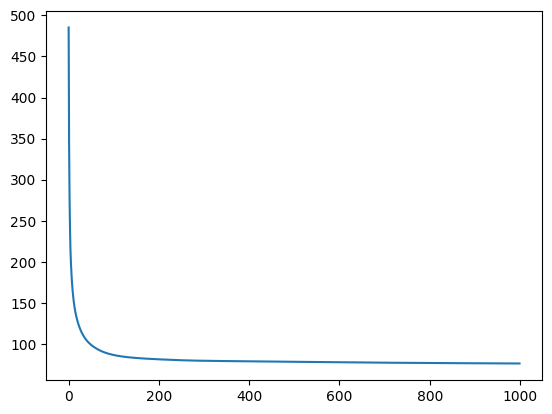

In [70]:
plt.plot(loss_als)